# Analyze output of .hdf5 files of hadrons code
June 12, 2023

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import subprocess as sp
import os 
import glob
import pandas as pd
import itertools

In [3]:
import gvar as gv
import h5py

In [4]:
%matplotlib notebook

m_f = 0.02 \
Want m_res < 10^-3

$ m_{phys} = m_f + m_{res} $ 

In [5]:
#  ## Code to explore hdf5 data
# def get_ds_dictionaries(name, node):
  
#     fullname = node.name
#     if isinstance(node, h5py.Dataset):
#     # node is a dataset
#         print(f'Dataset: {fullname}; adding to dictionary')
#         ds_dict[fullname] = node[:]
#         print('ds_dict size', len(ds_dict)) 
#     else:
#      # node is a group
#         print(f'Group: {fullname}; skipping')  
    
    
# ds_dict= {}    
# with h5py.File(output_dir+f1) as hf:
#     print(hf.visititems(get_ds_dictionaries))
# print(ds_dict)

# ds_dict= {}    
# with h5py.File(output_dir+f2) as hf:
#     print(hf.visititems(get_ds_dictionaries))
# print(ds_dict)


In [6]:
## Modules

def f_extract_meson(fname,meson_dict):
    
    with h5py.File(fname) as hf:
        meson_dict['corr']=np.asarray(hf['meson']['meson_0']['corr'][:].tolist())

    return meson_dict

def f_extract_wi(fname,wi_dict):
    
    with h5py.File(fname) as hf:
        for key1,value1 in hf['wardIdentity'].items():
            wi_dict[key1]=np.array(hf['wardIdentity'][key1][:].tolist())

    return wi_dict
    
    
def f_compute_mresidual(meas_dict):
    arr=np.array([i[0]/j[0] for i,j in zip(meas_dict['PJ5q'],meas_dict['meson_corr'])])

    return arr

def f_extract_wilson_flow(fname):
    
    keys=['flow_time','Plaq_density','Clover_density','top_charge']
    flow_vars=dict.fromkeys(keys)

    with h5py.File(fname) as hf:
        for idx,key in enumerate(keys):
            print(type(hf['FlowObservables']['FlowObservables_%s'%(idx)]['data']))
            flow_vars[key]=np.array(hf['FlowObservables']['FlowObservables_%s'%(idx)]['data'])
    
    return flow_vars


In [7]:

def f_get_meas(run_dir,epoch,drop_imag=True):
    
    f1='eta_s_2pt.{0}.h5'.format(epoch)
    f2='prop_gauge_DWF.{0}.h5'.format(epoch)

    meson_dict={}
    meson_dict=f_extract_meson(run_dir+f1,meson_dict)

    wi_dict={}
    wi_dict=f_extract_wi(run_dir+f2,wi_dict)
    
    ## Copy each element of wi_dict into meas_dict
    meas_dict=dict(wi_dict)
    
    meas_dict['meson_corr']=meson_dict['corr']
    
    m_res=f_compute_mresidual(meas_dict)
    meas_dict['m_res']=m_res
    
    if drop_imag==True:# Drop imaginary part
        for key in meas_dict.keys():
            if key!='m_res':
                meas_dict[key]=meas_dict[key][:,0]
    
    return meas_dict


def f_plot_mres(meas_dict,plot_ensemble=True,plot_corr=True):
    
    ## Plot correlators
#     if imag_part=True: 
#         y1=[i[0] for i in meas_dict['PJ5q']]
#         y2=[i[0] for i in meas_dict['meson_corr']]
    
    
    y1=meas_dict['PJ5q']
    y2=meas_dict['meson_corr']
    x=np.arange(y1.shape[0])

    if plot_corr: 
        plt.figure()
        if plot_ensemble: 
            plt.errorbar(x,gv.mean(y1),gv.sdev(y1),linestyle='',marker='*',label='Axial')
            plt.errorbar(x,gv.mean(y2),gv.sdev(y2),linestyle='',marker='o',label='meson')

        else: 
            plt.plot(x,y1,linestyle='',marker='*',label='Axial')
            plt.plot(x,y2,linestyle='',marker='o',label='meson')

        plt.yscale('log')
        plt.ylabel('correlator')
        plt.legend()
    
    
    ## Plot residual mass
    plt.figure()
    if plot_ensemble: 
        plt.errorbar(x,gv.mean(meas_dict['m_res']),gv.sdev(meas_dict['m_res']),linestyle='',marker='*')
    else: 
        plt.plot(x,meas_dict['m_res'],linestyle='',marker='*')
    plt.ylabel("residual mass")


In [8]:
def f_get_meas_ensemble(run_dir,epoch_list,imag_part=False):
    
    lst=[]
    for epoch in epoch_list:
        lst.append(f_get_meas(run_dir,epoch))
    
    keys = lst[0].keys()
    avg_dict={}
    
    for key in keys: 
        if (imag_part==True and key!='m_res'): # If input has imaginary part in array, extract real part
            a1=np.array([i[key][:,0]for i in lst])
        else: 
            a1=np.array([i[key] for i in lst])
            
            
        lgth=a1.shape[1]
        # Average over samples for each t-correlator
        avg_dict[key]=np.array([gv.dataset.avg_data(a1[:,i]) for i in range(lgth)])
    
    return avg_dict


### Plot mres

In [9]:
top_dir='/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_june15_mobius/dm_tests/meas_mobius/'

run_dir=top_dir+'run4_/test_1_no_wflow/meas_run_Lx-16_Lt-32_Ls-16_beta-10.8_mf-0.1/070623_015744-tioga/'


### Plot single mesurement

In [10]:
# run_dir=top_dir+'run4_/meas_run_Lx-16_Lt-32_Ls-32_beta-10.8_mf-0.1/070623_030339-tioga/'

# for epoch in [45,55,65,75]:
#     m1=f_get_meas(run_dir,epoch,True)
#     f_plot_mres(m1,False)

### Plot ensemble

<IPython.core.display.Javascript object>


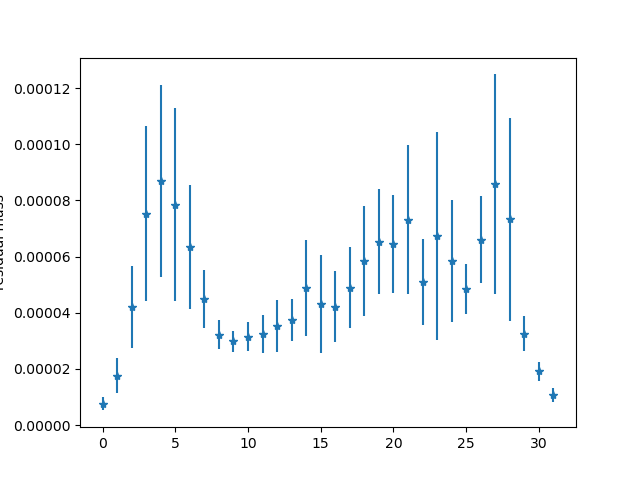

In [11]:
run_dir=top_dir+'run4_/meas_run_Lx-16_Lt-32_Ls-16_beta-10.8_mf-0.1/070923_043516-tioga/'

avg_dict=f_get_meas_ensemble(run_dir,np.arange(80,250,10))
f_plot_mres(avg_dict,plot_ensemble=True,plot_corr=False)


<IPython.core.display.Javascript object>


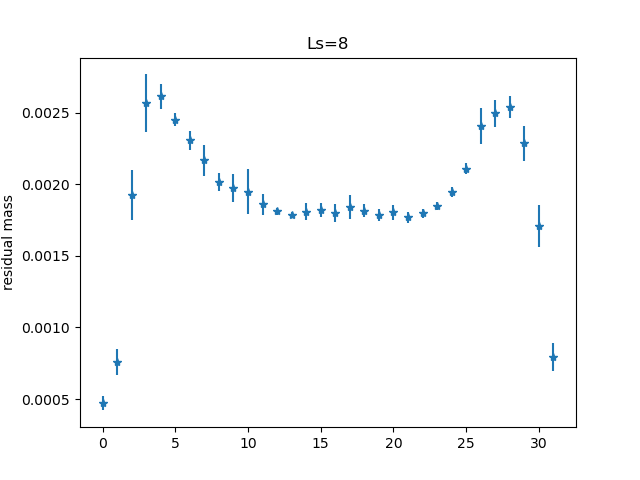

<IPython.core.display.Javascript object>


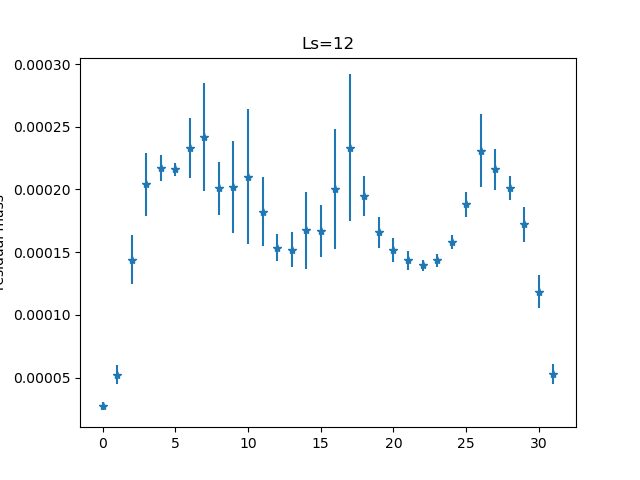

<IPython.core.display.Javascript object>


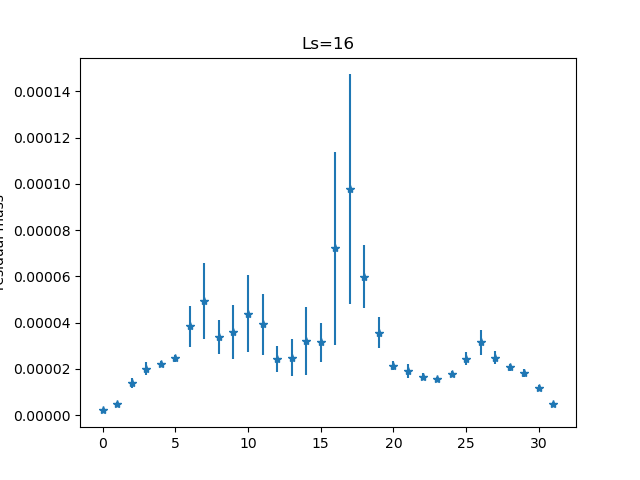

<IPython.core.display.Javascript object>


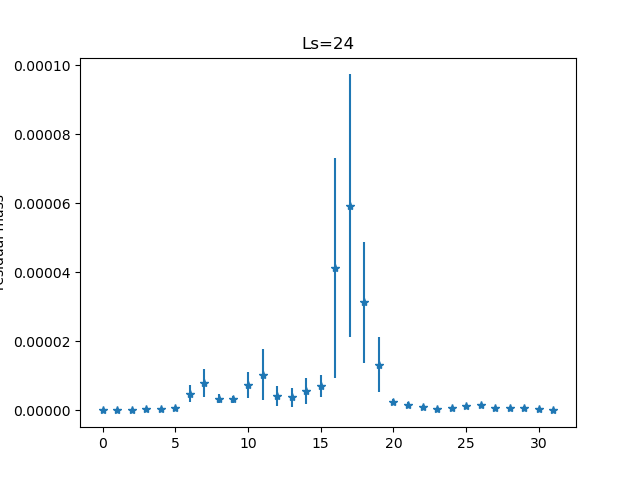

<IPython.core.display.Javascript object>


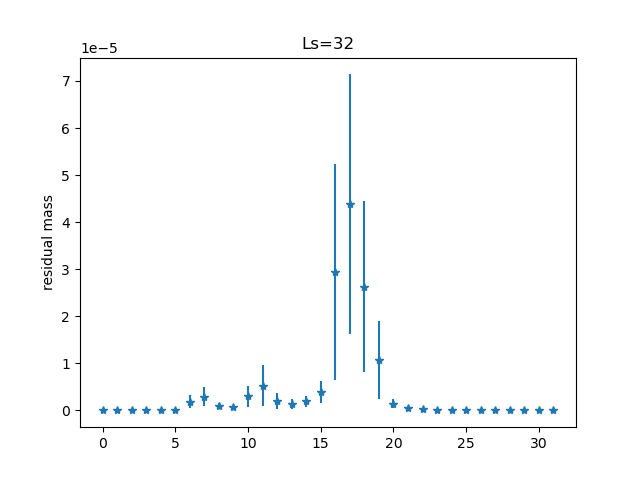

<IPython.core.display.Javascript object>


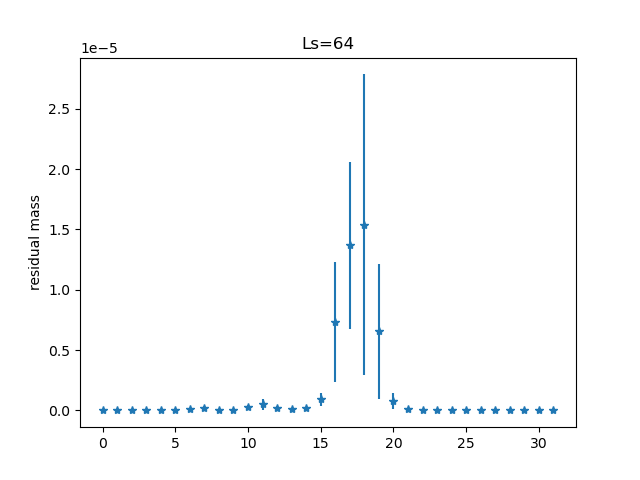

In [12]:
run_dir=top_dir+'run4_/test_2_ls16_vary_m_and_ls/meas_run_Lx-16_Lt-32_Ls-16_beta-10.8_mf-0.1/'

ls_list=[int(i.split('/')[-1].split('_')[0].split('ls')[-1]) for i in glob.glob(run_dir+'ls*')]
ls_list.sort()
for ls in ls_list:
    fldr=glob.glob(run_dir+'ls%s*'%(ls))[0]
    avg_dict=f_get_meas_ensemble(fldr+'/',np.arange(80,150,20))
    f_plot_mres(avg_dict,plot_ensemble=True,plot_corr=False)
    plt.title("Ls=%s"%(ls))

## Wilson flow

In [177]:
fname='/usr/WS2/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_june15_mobius/dm_tests/meas_mobius/run3_/wilson_flow_test/meas_run_Lx-16_Lt-32_Ls-16_beta-10.8_mf-0.1/063023_035356-tioga_wflow_and_spectrum/Wflow_.100.h5'

In [178]:
flow_vars=f_extract_wilson_flow(fname)

<class 'h5py._hl.dataset.Dataset'>
<class 'h5py._hl.dataset.Dataset'>
<class 'h5py._hl.dataset.Dataset'>
<class 'h5py._hl.dataset.Dataset'>


<IPython.core.display.Javascript object>


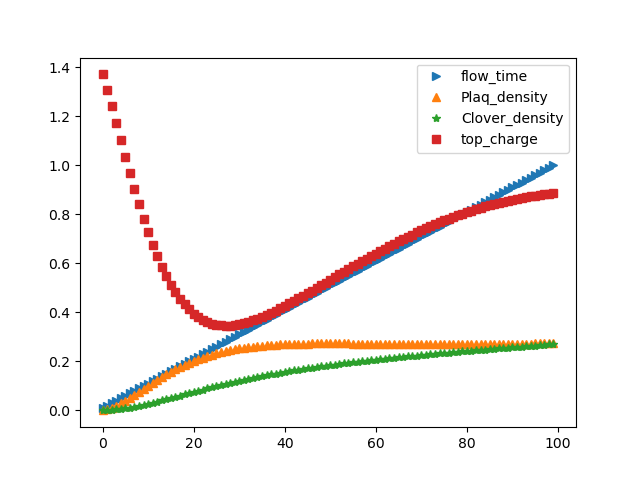

In [183]:
# Plot Wilson flow results

keys=['flow_time','Plaq_density','Clover_density','top_charge']

plt.figure()
for key,marker in zip(keys,itertools.cycle('>^*sDHPdpx_')):
    plt.plot(flow_vars[key],linestyle='',marker=marker,label=key)
    
plt.legend(loc='best')